In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
import shap

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
first_items_list = os.listdir(path)

In [4]:
first_items_list

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

In [5]:
# https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost
# edited by Max (Jongyun Han)

def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)!='category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == 'float':
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
            elif str(col_type)[:4] == 'bool':
                continue
            else:
                raise 'unknown datatype'
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df.copy()

In [6]:
def read_parquet_files(train_or_test='train'):
    pq_folders_path = path + f"{train_or_test}.parquet/"
    folders_list = os.listdir(pq_folders_path)

    pq_list = []
    
    for folder in tqdm(folders_list):
        files_path = pq_folders_path + '/' + folder
        files_list = os.listdir(files_path)
        for file in files_list:
            if '.parquet' in file:
                pq_df = pd.read_parquet(files_path + '/' + file)

                if train_or_test == 'train':
                    cols_to_drop = [col for col in pq_df.columns if 'responder' in col]
                    cols_to_drop.remove('responder_6')
                    pq_df = pq_df.drop(cols_to_drop, axis=1)
                
                pq_list.append(pq_df)

    return reduce_mem_usage(pd.concat(pq_list, ignore_index=True), False)

In [7]:
train_scan = pl.scan_parquet(path + 'train.parquet/')
test_scan = pl.scan_parquet(path + 'test.parquet/')

In [8]:
train_symbol_ids_list = sorted(train_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(train_symbol_ids_list))
train_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [9]:
test_symbol_ids_list = sorted(test_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(test_symbol_ids_list))
test_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [10]:
unique_symbol_ids_list = sorted(list(set(train_symbol_ids_list + test_symbol_ids_list)))
print(len(unique_symbol_ids_list))
unique_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [11]:
train_df = read_parquet_files()
y_sr = train_df['responder_6']
train_df = train_df.drop('responder_6', axis=1)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


Memory usage of dataframe is 14427.07 MB
Memory usage after optimization is: 7415.78 MB
Decreased by 48.6%
(47127338, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143
4,0,0,14,0.440674,NaN,NaN,NaN,NaN,NaN,0.955078,0.262451,0.344482,-0.613770,44,3,16,-0.947266,-0.030014,-0.502441,NaN,0.645996,NaN,-1.844727,-1.586914,-0.182007,NaN,-0.969727,-0.673828,-1.282227,-1.399414,NaN,NaN,0.043823,-0.320312,-0.031708,NaN,NaN,NaN,-0.088440,-0.995117,-2.634766,-0.196411,-0.618652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.013672,-2.320312,-3.710938,NaN,1.253906,NaN,NaN,0.476074,NaN,-0.771973,2.843750,NaN,1.379883,0.411865,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.948730,-0.136841,-0.447754,-1.141602,0.099609,-0.662109,NaN,NaN,3.677734,2.792969,2.619141,3.417969


In [12]:
train_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47127338 entries, 0 to 47127337
Data columns (total 83 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   date_id     47127338 non-null  int16  
 1   time_id     47127338 non-null  int16  
 2   symbol_id   47127338 non-null  int8   
 3   weight      47127338 non-null  float16
 4   feature_00  43945286 non-null  float16
 5   feature_01  43945286 non-null  float16
 6   feature_02  43945286 non-null  float16
 7   feature_03  43945286 non-null  float16
 8   feature_04  43945286 non-null  float16
 9   feature_05  47127338 non-null  float16
 10  feature_06  47127338 non-null  float16
 11  feature_07  47127338 non-null  float16
 12  feature_08  46827091 non-null  float16
 13  feature_09  47127338 non-null  int8   
 14  feature_10  47127338 non-null  int8   
 15  feature_11  47127338 non-null  int16  
 16  feature_12  47127338 non-null  float16
 17  feature_13  47127338 non-null  float16
 18  

In [13]:
test_df = read_parquet_files(train_or_test='test')
test_row_id_sr = test_df['row_id']
test_df = test_df.drop(['row_id', 'is_scored'], axis=1)
print(test_df.shape)
test_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.95it/s]

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 26.0%
(39, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
5,0,0,5,2.605469,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
6,0,0,6,1.047852,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
7,0,0,7,4.230469,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
8,0,0,8,2.599609,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,

In [14]:
test_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 83 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_id     39 non-null     int8   
 1   time_id     39 non-null     int8   
 2   symbol_id   39 non-null     int8   
 3   weight      39 non-null     float16
 4   feature_00  39 non-null     float16
 5   feature_01  39 non-null     float16
 6   feature_02  39 non-null     float16
 7   feature_03  39 non-null     float16
 8   feature_04  39 non-null     float16
 9   feature_05  39 non-null     float16
 10  feature_06  39 non-null     float16
 11  feature_07  39 non-null     float16
 12  feature_08  39 non-null     float16
 13  feature_09  39 non-null     float16
 14  feature_10  39 non-null     float16
 15  feature_11  39 non-null     float16
 16  feature_12  39 non-null     float16
 17  feature_13  39 non-null     float16
 18  feature_14  39 non-null     float16
 19  feature_15  0 non-null      flo

In [15]:
lags_df = read_parquet_files(train_or_test='lags')
print(lags_df.shape)
lags_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 45.1%
(39, 12)


,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442139,-0.322510,0.143555,-0.926758,-0.782227,-0.036591,-1.305664,-0.795898,-0.143677
1,0,0,1,-0.651855,-1.708008,-0.894043,-1.065430,-1.871094,-0.615723,-1.163086,-1.206055,-1.246094
2,0,0,2,-0.656250,-0.264648,-0.893066,-1.511719,-1.033203,-0.378174,-1.574219,-1.863281,-0.027344
3,0,0,3,-0.188232,-0.190918,-0.701660,0.098450,-1.015625,-0.054993,0.329102,-0.965332,0.576660
4,0,0,4,-0.257568,-0.471436,-0.297363,0.074036,-0.324219,-0.597168,0.219849,-0.276367,-0.904785
5,0,0,5,0.027573,-0.020172,0.640137,-0.948242,-0.374268,-0.240356,-0.913574,-0.548828,-1.284180
6,0,0,6,-0.419678,-0.181274,-0.194092,0.667969,0.937012,0.517578,0.896484,1.069336,1.579102
7,0,0,7,-0.114136,-0.198486,-0.200073,-0.409912,-0.135132,-0.182861,-0.492188,-0.142944,-0.202026
8,0,0,8,-0.374268,0.092102,0.294678,0.403076,2.060547,-0.225098,0.956543,2.185547,-0.435791
9,0,0,9,-0.529297,0.040100,-0.333008,-0.958984,-1.318359,-0.774414,-0.716309,-1.471680,-1.107422


In [16]:
sample_df = pd.read_csv(path + 'sample_submission.csv')
print(sample_df.shape)
sample_df

(39, 2)


,row_id,responder_6
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [17]:
def one_hot_cat_cols(df):
    for v in tqdm(unique_symbol_ids_list):
        new_col_name = 'symbol_id_' + str(v)
        df[new_col_name] = (df['symbol_id'] == v).astype(int)
    
    #df = df.drop('symbol_id', axis=1)

    return

In [18]:
one_hot_cat_cols(train_df)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 10.94it/s]

(47127338, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
one_hot_cat_cols(test_df)
print(test_df.shape)
test_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 4875.93it/s]

(39, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
sample_train_df = train_df.sample(frac=0.1)
print(sample_train_df.shape)
sample_train_df.head()

(4712734, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
2074751,178,437,10,1.833008,NaN,NaN,NaN,NaN,NaN,0.549316,0.330322,1.581055,-1.732422,42,5,150,-0.521973,-0.487061,-0.456543,-0.075623,0.394531,0.251221,-1.719727,0.800293,-0.240112,NaN,0.046997,0.132202,-1.353516,-0.600586,NaN,NaN,0.407715,-0.376709,-0.100586,NaN,-0.866699,-0.610352,-0.874023,-0.978516,0.470947,-2.593750,-2.845703,1.200195,-0.983398,-1.083984,-0.013763,-0.983887,0.026993,1.653320,0.963867,0.680176,0.099731,0.486572,0.373047,-0.195923,0.847168,0.906738,-0.928711,0.413818,1.281250,0.656250,1.107422,0.008972,1.124023,1.276367,0.378174,1.509766,1.005859,-0.687012,0.239014,-0.743164,-0.309082,-0.393555,-0.535645,-0.342285,-0.425537,0.228882,0.282227,-0.308105,-0.104675,0.197021,0.289062,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32686421,1306,42,5,3.669922,3.894531,2.250000,2.250000,2.595703,2.031250,0.741211,0.420410,0.807617,-0.020721,2,10,171,-0.576172,0.263916,0.187988,-0.937012,-0.525391,-0.542480,-1.699219,0.079468,0.161865,0.280273,1.502930,0.159424,1.446289,1.351562,-1.104492,-0.153931,0.479492,-0.542480,-0.693359,0.359375,2.021484,1.499023,2.283203,2.099609,1.868164,-0.467773,-0.084534,NaN,0.072754,1.194336,NaN,-0.148438,-0.276367,0.318115,1.380859,1.241211,-0.001540,1.485352,NaN,-1.082031,0.943848,NaN,0.139648,-0.070190,-0.303467,0.911133,0.705566,-0.589355,1.088867,-0.966309,-0.481201,-0.433838,-0.376953,-1.529297,-0.530762,-0.555176,0.154663,-0.013878,-0.476562,0.333740,0.348145,-0.337891,-0.301514,-0.140625,-0.151489,-0.255859,-0.282715,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42124054,1564,429,33,1.573242,0.035553,0.355957,0.406738,0.316895,-1.048828,0.003839,0.883789,0.002951,-0.278320,11,7,76,-0.338135,0.001291,-0.242065,-0.441895,-0.751953,-0.582031,0.597168,0.580566,-0.416504,-0.300293,-0.679688,-0.012199,1.853516,-0.636230,-0.229248,-0.113037,-0.206055,-0.346191,-0.650879,-0.241089,1.307617,0.059631,1.006836,1.015625,-0.080627,0.232666,0.464844,-0.610840,0.290283,0.230347,-0.276855,0.602539,-0.318359,-0.606445,0.091187,-0.473633,0.445801,-0.145630,-0.681641,0.012016,-0.114441,-0.257568,-0.012512,0.239502,-0.566895,-0.325195,-1.036133,-0.025314,-0.398926,0.681152,-0.382568,-0.232788,-0.270508,-0.358154,0.314697,-0.224243,0.141602,-0.147461,-0.673340,-0.092346,-0.293457,-0.228394,-0.372803,0.058075,-0.006832,-0.242798,-0.308105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
25874819,1123,583,31,0.921875,0.553711,-1.192383,0.326416,0.210938,1.133789,-0.531738,0.178223,0.461670,0.489502,44,3,24,0.131836,-0.274902,-0.166748,-0.

In [21]:
sample_y_sr = y_sr.iloc[sample_train_df.index]
print(sample_y_sr.shape)
sample_y_sr.head()

(4712734,)


2074751    -0.437500
32686421   -1.266602
42124054    0.105347
25874819   -0.026077
20155859    0.562500
Name: responder_6, dtype: float16

In [22]:
feature_cols = [col for col in train_df.columns if 'feature' in col]
print(len(feature_cols))
feature_cols

79


['feature_00',
 'feature_01',
 'feature_02',
 'feature_03',
 'feature_04',
 'feature_05',
 'feature_06',
 'feature_07',
 'feature_08',
 'feature_09',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_

In [23]:
n_splits = 5

In [28]:
def lgb_train(train_data, y):
    #X = train_data.drop(['weight', 'responder_6', 'row_id', 'is_scored'], axis=1)
    X = train_data.drop(['date_id', 'time_id', 'symbol_id'], axis=1)
    #y = train_data['responder_6']
    weights = train_data['weight']
    print(X.shape)
    display(X.head())
     
    oof = np.zeros(len(y), dtype=float)

    models_list = []

    base_params = {
        'verbosity': -1,
        'learning_rate': 0.09,
        'feature_fraction': 0.8,
        'device': 'gpu',
        'early_stopping_round': 50,
    }

    cv_fold = KFold(n_splits=n_splits, shuffle=True)#, shuffle=True, random_state=6)

    for fold, (train_idx, test_idx) in enumerate(cv_fold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        #weights_train, weights_val = weights.iloc[train_idx], weights.iloc[test_idx]

        model = LGBMRegressor(
            **base_params,
            n_estimators=100000
        )

        #model.fit(train_dmatrix, eval_set=val_dmatrix, verbose=10)
        
        #model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight_eval_set=[weights_train, weights_val], verbose=50)
        #model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], callbacks=[log_evaluation(period=50)])
        
        oof[test_idx] = model.predict(X_val)

        plt.figure()
        lgb.plot_metric(model)
        plt.ylim(0, 1)
        plt.show()

        '''plt.figure(figsize=(10, 6))

        eval_results = model.evals_result_

        # Extract metrics
        train_rmse = eval_results['validation_0']['rmse']
        val_rmse = eval_results['validation_1']['rmse']
        plt.plot(train_rmse, label='Training RMSE')
        plt.plot(val_rmse, label='Validation RMSE')
        plt.ylabel('RMSE')
        plt.title('Training vs Validation RMSE')
        
        # Plot the results
        plt.xlabel('Boosting Rounds')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()'''

        #print(model.score(X_val, y_val, sample_weight=weights_val))

        models_path = path + 'my_folder/models/20241224_03/'

        if not os.path.exists(models_path):
            os.makedirs(models_path)

        with open(models_path + f"lgb_model_{fold}.pkl", 'wb') as file:
            pickle.dump(model, file)

    print('R2 score is:', r2_score(y, oof))#, sample_weight=weights))
    print('Weighted R2 score is:', r2_score(y, oof, sample_weight=weights))

    return

(4712734, 119)


,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
2074751,1.833008,NaN,NaN,NaN,NaN,NaN,0.549316,0.330322,1.581055,-1.732422,42,5,150,-0.521973,-0.487061,-0.456543,-0.075623,0.394531,0.251221,-1.719727,0.800293,-0.240112,NaN,0.046997,0.132202,-1.353516,-0.600586,NaN,NaN,0.407715,-0.376709,-0.100586,NaN,-0.866699,-0.610352,-0.874023,-0.978516,0.470947,-2.593750,-2.845703,1.200195,-0.983398,-1.083984,-0.013763,-0.983887,0.026993,1.653320,0.963867,0.680176,0.099731,0.486572,0.373047,-0.195923,0.847168,0.906738,-0.928711,0.413818,1.281250,0.656250,1.107422,0.008972,1.124023,1.276367,0.378174,1.509766,1.005859,-0.687012,0.239014,-0.743164,-0.309082,-0.393555,-0.535645,-0.342285,-0.425537,0.228882,0.282227,-0.308105,-0.104675,0.197021,0.289062,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32686421,3.669922,3.894531,2.250000,2.250000,2.595703,2.031250,0.741211,0.420410,0.807617,-0.020721,2,10,171,-0.576172,0.263916,0.187988,-0.937012,-0.525391,-0.542480,-1.699219,0.079468,0.161865,0.280273,1.502930,0.159424,1.446289,1.351562,-1.104492,-0.153931,0.479492,-0.542480,-0.693359,0.359375,2.021484,1.499023,2.283203,2.099609,1.868164,-0.467773,-0.084534,NaN,0.072754,1.194336,NaN,-0.148438,-0.276367,0.318115,1.380859,1.241211,-0.001540,1.485352,NaN,-1.082031,0.943848,NaN,0.139648,-0.070190,-0.303467,0.911133,0.705566,-0.589355,1.088867,-0.966309,-0.481201,-0.433838,-0.376953,-1.529297,-0.530762,-0.555176,0.154663,-0.013878,-0.476562,0.333740,0.348145,-0.337891,-0.301514,-0.140625,-0.151489,-0.255859,-0.282715,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42124054,1.573242,0.035553,0.355957,0.406738,0.316895,-1.048828,0.003839,0.883789,0.002951,-0.278320,11,7,76,-0.338135,0.001291,-0.242065,-0.441895,-0.751953,-0.582031,0.597168,0.580566,-0.416504,-0.300293,-0.679688,-0.012199,1.853516,-0.636230,-0.229248,-0.113037,-0.206055,-0.346191,-0.650879,-0.241089,1.307617,0.059631,1.006836,1.015625,-0.080627,0.232666,0.464844,-0.610840,0.290283,0.230347,-0.276855,0.602539,-0.318359,-0.606445,0.091187,-0.473633,0.445801,-0.145630,-0.681641,0.012016,-0.114441,-0.257568,-0.012512,0.239502,-0.566895,-0.325195,-1.036133,-0.025314,-0.398926,0.681152,-0.382568,-0.232788,-0.270508,-0.358154,0.314697,-0.224243,0.141602,-0.147461,-0.673340,-0.092346,-0.293457,-0.228394,-0.372803,0.058075,-0.006832,-0.242798,-0.308105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
25874819,0.921875,0.553711,-1.192383,0.326416,0.210938,1.133789,-0.531738,0.178223,0.461670,0.489502,44,3,24,0.131836,-0.274902,-0.166748,-0.607422,-0.454834,-0.399414,-1.854492,-0.610352,-1.612305,-0.205322,-0.5

[50]	training's l2: 0.778971	valid_1's l2: 0.782573
[100]	training's l2: 0.77371	valid_1's l2: 0.779814
[150]	training's l2: 0.769688	valid_1's l2: 0.778252
[200]	training's l2: 0.765712	valid_1's l2: 0.776504
[250]	training's l2: 0.762265	valid_1's l2: 0.775209
[300]	training's l2: 0.75897	valid_1's l2: 0.773894
[350]	training's l2: 0.756294	valid_1's l2: 0.773201
[400]	training's l2: 0.753378	valid_1's l2: 0.772292
[450]	training's l2: 0.750924	valid_1's l2: 0.771723
[500]	training's l2: 0.748425	valid_1's l2: 0.771112
[550]	training's l2: 0.745929	valid_1's l2: 0.770291
[600]	training's l2: 0.743617	valid_1's l2: 0.769811
[650]	training's l2: 0.741389	valid_1's l2: 0.769192
[700]	training's l2: 0.73923	valid_1's l2: 0.768733
[750]	training's l2: 0.737262	valid_1's l2: 0.768297
[800]	training's l2: 0.735255	valid_1's l2: 0.767853
[850]	training's l2: 0.733379	valid_1's l2: 0.767383
[900]	training's l2: 0.731397	valid_1's l2: 0.766903
[950]	training's l2: 0.729214	valid_1's l2: 0.7661

<Figure size 640x480 with 0 Axes>

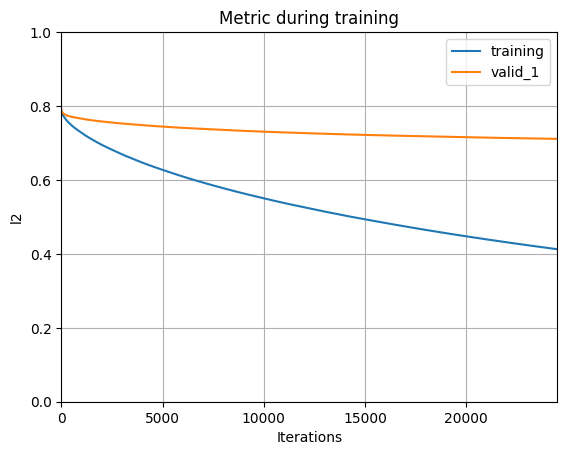

[50]	training's l2: 0.779063	valid_1's l2: 0.782136
[100]	training's l2: 0.773904	valid_1's l2: 0.77971
[150]	training's l2: 0.769361	valid_1's l2: 0.777607
[200]	training's l2: 0.765337	valid_1's l2: 0.775857
[250]	training's l2: 0.761617	valid_1's l2: 0.774206
[300]	training's l2: 0.758488	valid_1's l2: 0.773231
[350]	training's l2: 0.755725	valid_1's l2: 0.772438
[400]	training's l2: 0.752907	valid_1's l2: 0.771587
[450]	training's l2: 0.750398	valid_1's l2: 0.770908
[500]	training's l2: 0.747922	valid_1's l2: 0.770217
[550]	training's l2: 0.74547	valid_1's l2: 0.769581
[600]	training's l2: 0.743102	valid_1's l2: 0.768934
[650]	training's l2: 0.740896	valid_1's l2: 0.76843
[700]	training's l2: 0.738764	valid_1's l2: 0.767948
[750]	training's l2: 0.736664	valid_1's l2: 0.767485
[800]	training's l2: 0.734599	valid_1's l2: 0.767026
[850]	training's l2: 0.732671	valid_1's l2: 0.766565
[900]	training's l2: 0.730724	valid_1's l2: 0.766031
[950]	training's l2: 0.728876	valid_1's l2: 0.7656

<Figure size 640x480 with 0 Axes>

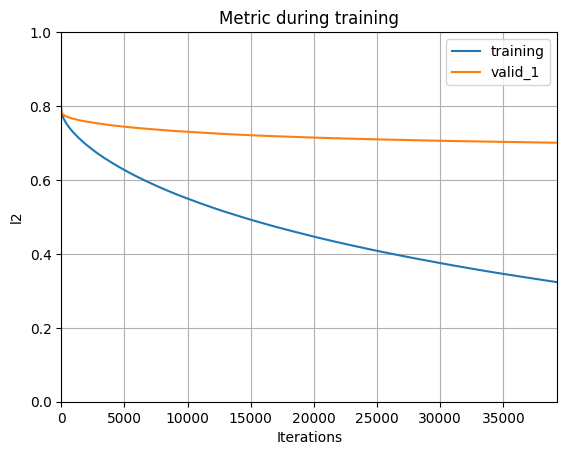

[50]	training's l2: 0.779556	valid_1's l2: 0.779651
[100]	training's l2: 0.774279	valid_1's l2: 0.77695
[150]	training's l2: 0.769817	valid_1's l2: 0.774938
[200]	training's l2: 0.766327	valid_1's l2: 0.773704
[250]	training's l2: 0.76279	valid_1's l2: 0.77221
[300]	training's l2: 0.75914	valid_1's l2: 0.770696
[350]	training's l2: 0.756174	valid_1's l2: 0.769657
[400]	training's l2: 0.753401	valid_1's l2: 0.768675
[450]	training's l2: 0.751023	valid_1's l2: 0.768135
[500]	training's l2: 0.748425	valid_1's l2: 0.767203
[550]	training's l2: 0.746185	valid_1's l2: 0.766716
[600]	training's l2: 0.743871	valid_1's l2: 0.766156
[650]	training's l2: 0.74169	valid_1's l2: 0.765579
[700]	training's l2: 0.739504	valid_1's l2: 0.764992
[750]	training's l2: 0.737388	valid_1's l2: 0.764415
[800]	training's l2: 0.735376	valid_1's l2: 0.763994
[850]	training's l2: 0.733269	valid_1's l2: 0.763327
[900]	training's l2: 0.731385	valid_1's l2: 0.762883
[950]	training's l2: 0.729469	valid_1's l2: 0.76235


<Figure size 640x480 with 0 Axes>

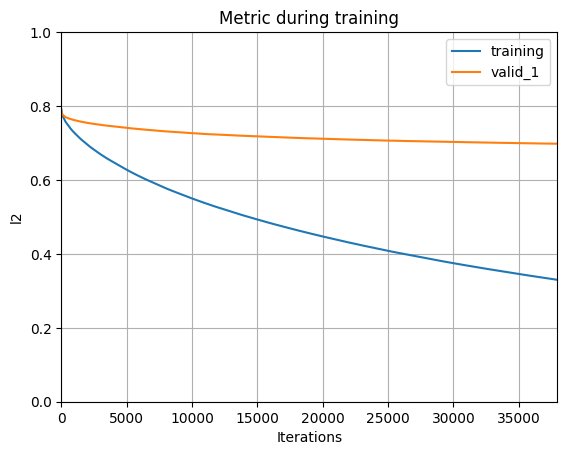

[50]	training's l2: 0.779362	valid_1's l2: 0.781069
[100]	training's l2: 0.774123	valid_1's l2: 0.778484
[150]	training's l2: 0.769903	valid_1's l2: 0.776777
[200]	training's l2: 0.766192	valid_1's l2: 0.775462
[250]	training's l2: 0.762503	valid_1's l2: 0.773706
[300]	training's l2: 0.759311	valid_1's l2: 0.7726
[350]	training's l2: 0.756576	valid_1's l2: 0.771904
[400]	training's l2: 0.753899	valid_1's l2: 0.771287
[450]	training's l2: 0.751252	valid_1's l2: 0.770371
[500]	training's l2: 0.748876	valid_1's l2: 0.76973
[550]	training's l2: 0.746555	valid_1's l2: 0.769153
[600]	training's l2: 0.744321	valid_1's l2: 0.768572
[650]	training's l2: 0.741995	valid_1's l2: 0.767879
[700]	training's l2: 0.739807	valid_1's l2: 0.767231
[750]	training's l2: 0.737523	valid_1's l2: 0.76653
[800]	training's l2: 0.735401	valid_1's l2: 0.766121
[850]	training's l2: 0.733279	valid_1's l2: 0.765635
[900]	training's l2: 0.731352	valid_1's l2: 0.765205
[950]	training's l2: 0.729336	valid_1's l2: 0.76462

<Figure size 640x480 with 0 Axes>

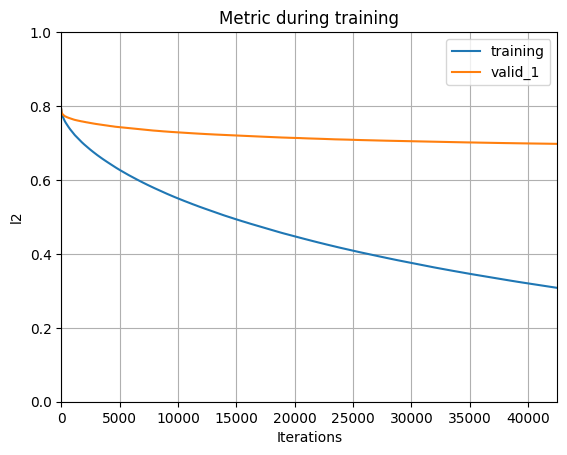

[50]	training's l2: 0.779066	valid_1's l2: 0.781858
[100]	training's l2: 0.773773	valid_1's l2: 0.779009
[150]	training's l2: 0.769632	valid_1's l2: 0.777159
[200]	training's l2: 0.766118	valid_1's l2: 0.775881
[250]	training's l2: 0.76236	valid_1's l2: 0.774208
[300]	training's l2: 0.759395	valid_1's l2: 0.77327
[350]	training's l2: 0.756209	valid_1's l2: 0.77197
[400]	training's l2: 0.753693	valid_1's l2: 0.7714
[450]	training's l2: 0.751211	valid_1's l2: 0.770597
[500]	training's l2: 0.748856	valid_1's l2: 0.769996
[550]	training's l2: 0.7465	valid_1's l2: 0.769398
[600]	training's l2: 0.744227	valid_1's l2: 0.768789
[650]	training's l2: 0.741961	valid_1's l2: 0.768249
[700]	training's l2: 0.739908	valid_1's l2: 0.767756
[750]	training's l2: 0.73792	valid_1's l2: 0.767332
[800]	training's l2: 0.735839	valid_1's l2: 0.766802
[850]	training's l2: 0.733776	valid_1's l2: 0.766319
[900]	training's l2: 0.731705	valid_1's l2: 0.765808
[950]	training's l2: 0.729748	valid_1's l2: 0.765362
[1

<Figure size 640x480 with 0 Axes>

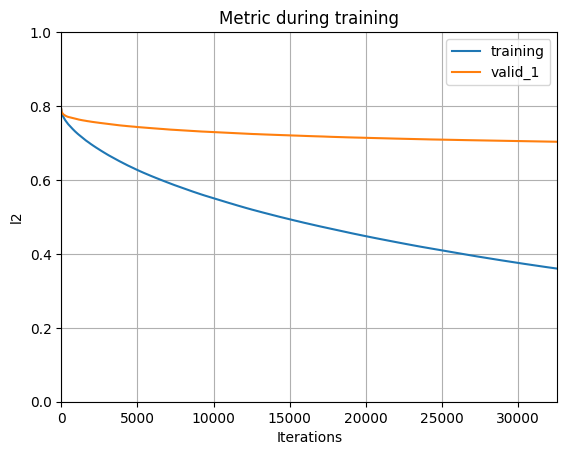

R2 score is: 0.11281586224826967
Weighted R2 score is: 0.11049928357960126


In [29]:
lgb_train(sample_train_df, sample_y_sr)